# Industrial Equipment Failure Prediction

## Context
Predicting equipment failures is a critical challenge in the industrial sector, as unexpected downtimes can lead to significant financial losses and operational disruptions. Leveraging machine learning models to analyze sensor data enables proactive maintenance strategies, improving reliability and efficiency.  
This project focuses on developing a predictive model to anticipate failures in industrial equipment using real-world sensor data.

---

## Content of Dataset
The dataset, sourced from a publicly available industrial monitoring collection, includes various features capturing operational parameters and sensor readings. Key attributes of the dataset:  
- **Time-series data:** Metrics recorded periodically from multiple sensors.  
- **Equipment information:** Details about machine types and operational conditions.  
- **Target variable:** Labels indicating normal operation or failure.  

Preliminary exploration and feature engineering will be crucial for uncovering patterns and extracting meaningful insights.

---

## Goals of the Project
This project aims to:  
1. Perform exploratory data analysis (EDA) to understand the dataset structure and key trends.  
2. Develop machine learning models to predict equipment failures accurately.  
3. Optimize models for deployment-ready performance.  
4. Explore the potential impact of predictions on maintenance schedules and cost reduction.  

Through this work, I seek to demonstrate proficiency in handling complex industrial datasets, applying predictive analytics, and deploying scalable solutions.

---


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import pickle

## Data preparation
- Download the data, read it with pandas
- Look at the data
- Make column names and values look uniform
- Check if all the columns read correctly
- Check if the failure variable needs any preparation

Data from https://www.kaggle.com/datasets/dnkumars/industrial-equipment-monitoring-dataset/data
### Reading the data

In [2]:
df = pd.read_csv("equipment_anomaly_data.csv")

In [3]:
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### Records count

In [4]:
df.shape

(7672, 7)

In [5]:
df.dtypes

temperature    float64
pressure       float64
vibration      float64
humidity       float64
equipment       object
location        object
faulty         float64
dtype: object

In [6]:
numerical = ['temperature', 'pressure', 'vibration', 'humidity']
categorical = list(df.dtypes[df.dtypes == 'object'].index)
print("Numerical features are :", numerical)
print("Categorical features are :", categorical)

Numerical features are : ['temperature', 'pressure', 'vibration', 'humidity']
Categorical features are : ['equipment', 'location']


In [7]:
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [8]:
df.faulty = (df.faulty > 0).astype(int)
df.faulty

0       0
1       0
2       0
3       0
4       0
       ..
7667    0
7668    0
7669    0
7670    1
7671    1
Name: faulty, Length: 7672, dtype: int64

## EDA – Exploratory Data Analysis
- Check missing values
- Look at the target variable (faulty)
- Look at numerical and categorical variables
### Checking missing values

In [9]:
df.isna().sum().sum()

np.int64(0)

There's no **NaN** values.
### Looking at the target variable *faulty*

In [10]:
df.faulty.value_counts(normalize=True)

faulty
0    0.900026
1    0.099974
Name: proportion, dtype: float64

In [11]:
df.faulty.mean().round(6)

np.float64(0.099974)

The target is imbalanced, but not so strongly.
### Looking at numerical and categorical variables

In [12]:
df.describe().round(2)

,temperature,pressure,vibration,humidity,faulty
count,7672.00,7672.00,7672.00,7672.00,7672.0
mean,70.92,35.74,1.61,50.02,0.1
std,16.20,10.38,0.73,11.84,0.3
min,10.27,3.62,-0.43,10.22,0.0
25%,62.78,29.49,1.17,42.61,0.0
50%,70.16,35.23,1.53,50.02,0.0
75%,77.57,41.16,1.92,57.34,0.0
max,149.69,79.89,4.99,89.98,1.0


In [13]:
(df.vibration < 0).sum()

np.int64(10)

The feature *vibration* could be curious when **negative**.
Nevertheless, the notion of vibration may consider an **acceleration measurement** that may be **negative** (deceleration).
That's why I won't consider the 10 negative values as wrong.

### Correlation matrix

In [14]:
corr = df[numerical].corr()
corr

,temperature,pressure,vibration,humidity
temperature,1.000000,0.049093,0.063448,0.000376
pressure,0.049093,1.000000,0.077577,-0.014706
vibration,0.063448,0.077577,1.000000,0.025175
humidity,0.000376,-0.014706,0.025175,1.000000


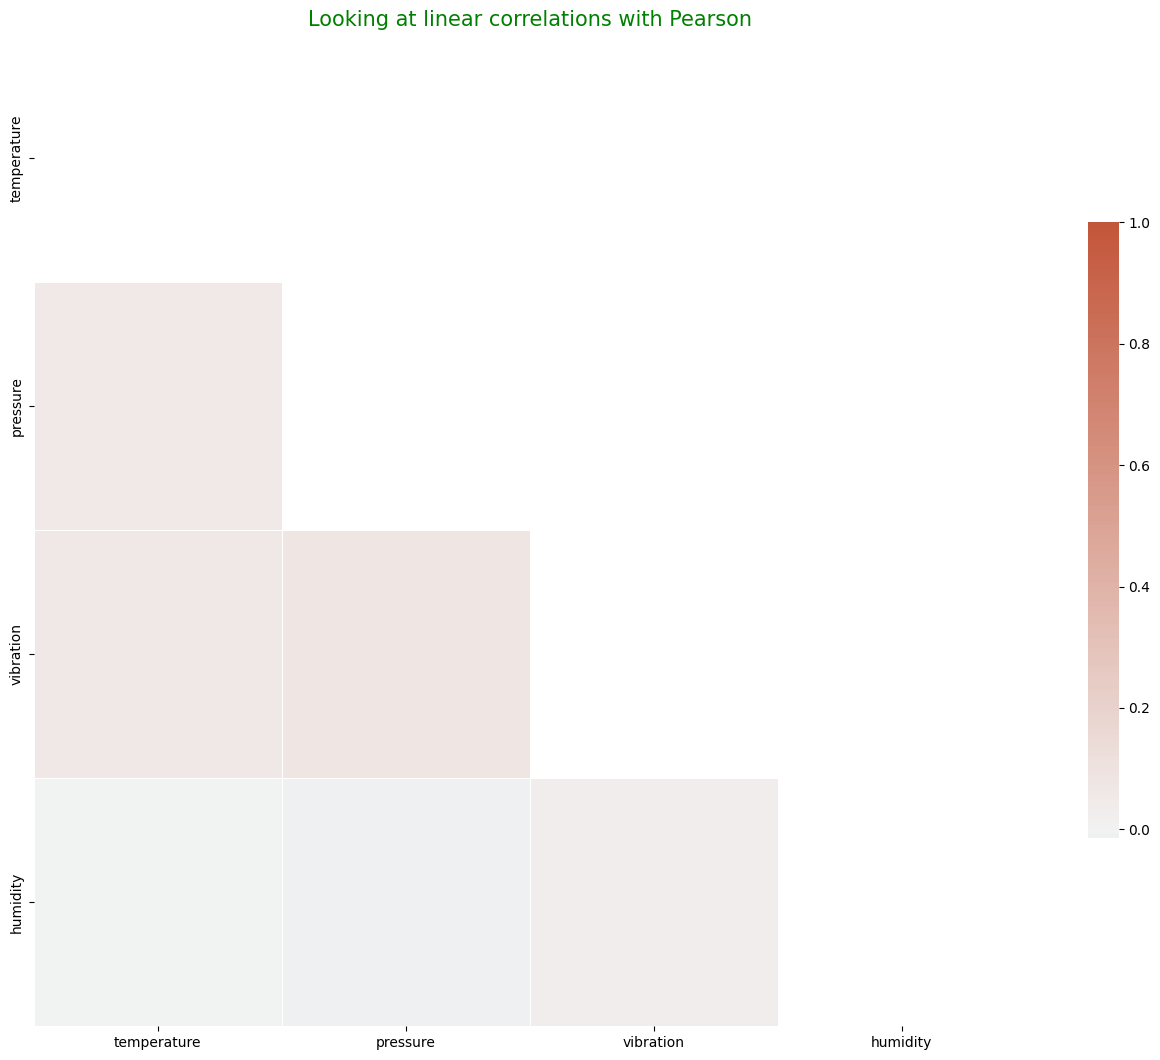

In [15]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(16, 16))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.grid(visible=False)
plt.title('Looking at linear correlations with Pearson',
          color='green', fontsize=15)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=False, linewidths=.5, cbar_kws={"shrink": .5});

**Correlations** between numerical features seem to be very **low**.

In [16]:
df[categorical].nunique()

equipment    3
location     5
dtype: int64

In [17]:
for cat in categorical:
    print(f"Values for {cat} : {df[cat].unique()}")

Values for equipment : ['turbine' 'compressor' 'pump']
Values for location : ['atlanta' 'chicago' 'san_francisco' 'new_york' 'houston']


## Setting up the validation framework
- Perform the train/validation/test split with Scikit-Learn

In [18]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=39)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=39)
len(df_train), len(df_val), len(df_test)

(4602, 1535, 1535)

In [19]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
y_full_train = df_full_train.faulty.values
y_train = df_train.faulty.values
y_val = df_val.faulty.values
y_test = df_test.faulty.values

In [21]:
del df_train['faulty']
del df_val['faulty']
del df_test['faulty']

## Feature importance: Failure rate and risk ratio
Feature importance analysis (part of EDA) - identifying which features affect our target variable
- Failure rate
- Risk ratio
- Mutual information
### Failure rate

In [22]:
df_full_train.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,64.739652,45.638355,1.954045,45.878434,turbine,san_francisco,0
1,75.062410,29.169678,1.642641,47.537256,turbine,new_york,0
2,77.556658,24.155665,2.706188,49.858019,compressor,san_francisco,0
3,67.057575,33.965620,2.489974,44.818347,pump,houston,0
4,77.910319,38.195755,1.591621,49.253946,compressor,san_francisco,0


Is an **equipment** more likely to fail than other ?

In [23]:
global_fail = df_full_train.faulty.mean()
global_fail

np.float64(0.09907120743034056)

In [24]:
fail_turbine = df_full_train[df_full_train.equipment == 'turbine'].faulty.mean()
fail_turbine

np.float64(0.09965803615046409)

In [25]:
global_fail - fail_turbine

np.float64(-0.0005868287201235278)

In [26]:
fail_compressor = df_full_train[df_full_train.equipment == 'compressor'].faulty.mean()
fail_compressor

np.float64(0.09820126397666505)

In [27]:
global_fail - fail_compressor

np.float64(0.0008699434536755118)

In [28]:
fail_pump = df_full_train[df_full_train.equipment == 'pump'].faulty.mean()
fail_pump

np.float64(0.09936055090998525)

In [29]:
global_fail - fail_pump

np.float64(-0.00028934347964468254)

It seem's the **differences** are very **low**.

Let's have the same look at the **location** feature.

In [30]:
fail_atlanta = df_full_train[df_full_train.location == 'atlanta'].faulty.mean()
fail_atlanta

np.float64(0.08747993579454254)

In [31]:
global_fail - fail_atlanta

np.float64(0.011591271635798026)

In [32]:
fail_chicago = df_full_train[df_full_train.location == 'chicago'].faulty.mean()
fail_chicago

np.float64(0.1008130081300813)

In [33]:
global_fail - fail_chicago

np.float64(-0.0017418006997407393)

In [34]:
fail_san_francisco = df_full_train[df_full_train.location == 'san_francisco'].faulty.mean()
fail_san_francisco

np.float64(0.11868686868686869)

In [35]:
global_fail - fail_san_francisco

np.float64(-0.019615661256528125)

In [36]:
fail_new_york = df_full_train[df_full_train.location == 'new_york'].faulty.mean()
fail_new_york

np.float64(0.08993399339933994)

In [37]:
global_fail - fail_new_york

np.float64(0.009137214031000623)

In [38]:
fail_houston = df_full_train[df_full_train.location == 'houston'].faulty.mean()
fail_houston

np.float64(0.09912767644726407)

In [39]:
global_fail - fail_houston

np.float64(-5.64690169235077e-05)

### Risk ratio

In [40]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).faulty.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_fail
    df_group['risk'] = df_group['mean'] / global_fail
    display(df_group)
    print()
    print()

equipment


,mean,count,diff,risk
equipment,,,,
compressor,0.098201,2057,-0.000870,0.991219
pump,0.099361,2033,0.000289,1.002921
turbine,0.099658,2047,0.000587,1.005923




location


,mean,count,diff,risk
location,,,,
atlanta,0.087480,1246,-0.011591,0.883001
chicago,0.100813,1230,0.001742,1.017581
houston,0.099128,1261,0.000056,1.000570
new_york,0.089934,1212,-0.009137,0.907771
san_francisco,0.118687,1188,0.019616,1.197996


The main conclusion is that there're nearly **20% more failures** than the mean in **San Francisco** and nearly **12% less** in **Atlanta**.
### Mutual information

In [41]:
def mutual_info_faulty_score(series):
    return mutual_info_score(series, df_full_train.faulty)

In [42]:
mi = df_full_train[categorical].apply(mutual_info_faulty_score)
mi.sort_values(ascending=False)

location     0.000652
equipment    0.000002
dtype: float64

That's the confirmation that the *location* may impact more than the *equipment* type. Nevertheless, **none** of these **categorical features** can be considered as **highly informative**.
## Feature importance: Correlation with Target
How about numerical columns?

In [43]:
df_full_train[numerical].corrwith(
    df_full_train.faulty).abs().sort_values(ascending=False)

vibration      0.432717
pressure       0.203662
temperature    0.189072
humidity       0.005382
dtype: float64

Correlations highlight moderate linear relationships, particularly for *vibration* the variable most correlated with failures with a coefficient of 0.43, while *humidity* seems to have little impact.
## One-hot encoding
- Use Scikit-Learn to encode categorical features

In [44]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)

In [45]:
X_train = dv.fit_transform(train_dict)
X_train.shape

(4602, 12)

In [46]:
dv.get_feature_names_out()

array(['equipment=compressor', 'equipment=pump', 'equipment=turbine',
       'humidity', 'location=atlanta', 'location=chicago',
       'location=houston', 'location=new_york', 'location=san_francisco',
       'pressure', 'temperature', 'vibration'], dtype=object)

In [47]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Training logistic regression with Scikit-Learn
- Train a model with Scikit-Learn
- Apply it to the validation dataset
- Calculate the ROC AUC

In [48]:
model = LogisticRegression(solver="lbfgs", max_iter=500, random_state=39, n_jobs=-1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500, n_jobs=-1, random_state=39)

In [49]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.09791165, 0.02415102, 0.15351501, ..., 0.10351844, 0.01690121,
       0.93983964], shape=(1535,))

In [50]:
roc_auc_score(y_val, y_pred)

np.float64(0.7438569424964936)

### Tuning the C-value

In [51]:
scores = {}
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(
        solver='lbfgs', C=C, max_iter=500, random_state=39, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred)
    scores[C] = round(auc_score, 3)
    print(f"C = {C}:\t roc_auc_score = {auc_score}")

C = 0.001:	 roc_auc_score = 0.7312575970079476
C = 0.01:	 roc_auc_score = 0.7522861150070127
C = 0.1:	 roc_auc_score = 0.7451051893408135
C = 1:	 roc_auc_score = 0.7438569424964936
C = 10:	 roc_auc_score = 0.7435857877512857
C = 100:	 roc_auc_score = 0.7437821411874709


In [52]:
scores

{0.001: np.float64(0.731),
 0.01: np.float64(0.752),
 0.1: np.float64(0.745),
 1: np.float64(0.744),
 10: np.float64(0.744),
 100: np.float64(0.744)}

In [53]:
print(f"The best `C` is {max(scores, key = scores.get)}.")

The best `C` is 0.01.


## Decision trees
- Training a decision tree
- Decision trees parameter tuning

In [54]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.9171458625525947)

### Tuning *max_depth*

In [55]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=39)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.699
   2 -> 0.822
   3 -> 0.873
   4 -> 0.889
   5 -> 0.886
   6 -> 0.889
  10 -> 0.914
  15 -> 0.896
  20 -> 0.918
None -> 0.918


### Tuning *min_samples_leaf*

In [56]:
scores = []

for depth in [15, 20]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=39)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

In [57]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [58]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=[
                                  'max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc       
max_depth            15     20
min_samples_leaf              
1                 0.896  0.918
5                 0.915  0.935
10                0.931  0.943
15                0.947  0.954
20                0.941  0.951
50                0.963  0.963
100               0.967  0.967
200               0.960  0.960
500               0.890  0.890

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

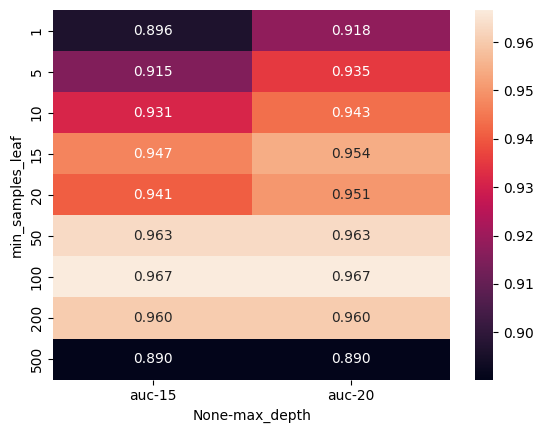

In [59]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

The best combination needs **max_depth = 20** and **min_samples_leaf = 100** for **AUC = 0.967**

In [60]:
dt = DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=39)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=39)

In [61]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vibration <= 2.89
|   |--- temperature <= 98.32
|   |   |--- temperature <= 45.01
|   |   |   |--- class: 1
|   |   |--- temperature >  45.01
|   |   |   |--- pressure <= 52.35
|   |   |   |   |--- pressure <= 18.77
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- pressure >  18.77
|   |   |   |   |   |--- humidity <= 67.73
|   |   |   |   |   |   |--- temperature <= 86.97
|   |   |   |   |   |   |   |--- humidity <= 30.89
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- humidity >  30.89
|   |   |   |   |   |   |   |   |--- vibration <= 2.28
|   |   |   |   |   |   |   |   |   |--- temperature <= 51.74
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- temperature >  51.74
|   |   |   |   |   |   |   |   |   |   |--- pressure <= 21.90
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- pressure >  21.90
|   |   |   |   |   |   |   |   |   |   |   |---

## Ensembles and Random Forest
- Training a Random Forest
- Tuning Random Forest

In [62]:
rf = RandomForestClassifier(n_estimators=10,
                            random_state=39,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("AUC :", round(roc_auc_score(y_val, y_pred), 3))

AUC : 0.924


### Tuning **n_estimators**

In [63]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=39,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [64]:
df_scores = pd.DataFrame(scores, columns=["n_estimators", "auc"])
df_scores.round(9)

,n_estimators,auc
0,10,0.923995
1,20,0.920769
2,30,0.923995
3,40,0.920769
4,50,0.921131
5,60,0.920769
6,70,0.923995
7,80,0.923633
8,90,0.923633
9,100,0.923633


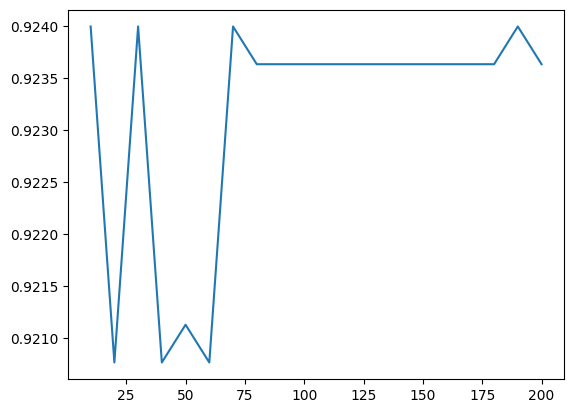

In [65]:
plt.plot(df_scores.n_estimators, df_scores.auc)

### Tuning **max_depth**

In [66]:
scores = []
for d in [5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=39,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [67]:
df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "auc"])
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.886010
1,5,20,0.879558
2,5,30,0.876332
3,5,40,0.876332
4,5,50,0.879558


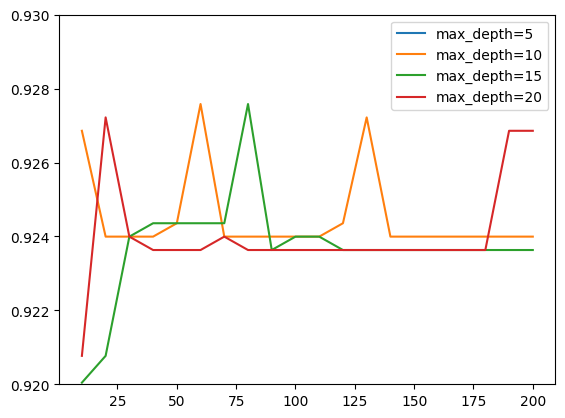

In [68]:
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)
    plt.ylim(0.92, 0.93)

plt.legend()

In [69]:
max_depth = 15

### Tuning **min_samples_leaf**

In [70]:
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 5):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=39,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [71]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

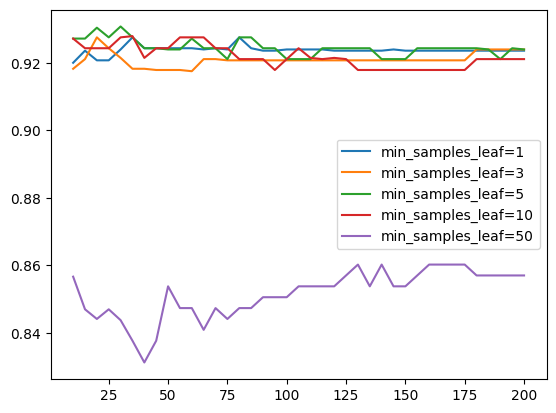

In [72]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]

    plt.plot(df_subset.n_estimators, df_subset.auc,
             # color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [73]:
min_samples_leaf = 3

### Best Random Forest model

In [74]:
rf = RandomForestClassifier(n_estimators=190,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=39,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("AUC:", auc)

AUC: 0.9768443197755959


## Gradient boosting and XGBoost
- Training the first model
- Performance monitoring
- Parsing xgboost's monitoring output
- XGBoost parameter tuning

In [75]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

### Training the first model

In [76]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',

    'seed': 39,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [77]:
y_pred = model.predict(dval)

In [78]:
roc_auc_score(y_val, y_pred)

np.float64(0.9752828424497427)

### Performance Monitoring

In [79]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [80]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [81]:
s = output.stdout

In [82]:
print(s[:200])

[0]	train-auc:0.94753	val-auc:0.94269
[5]	train-auc:0.99085	val-auc:0.96755
[10]	train-auc:0.99787	val-auc:0.97461
[15]	train-auc:0.99888	val-auc:0.97883
[20]	train-auc:0.99948	val-auc:0.97914
[25]	tr


### Parsing xgboost's monitoring output

In [83]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [84]:
df_score = parse_xgb_output(output)

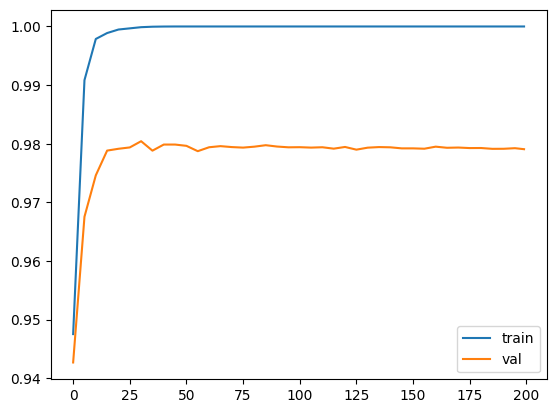

In [85]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

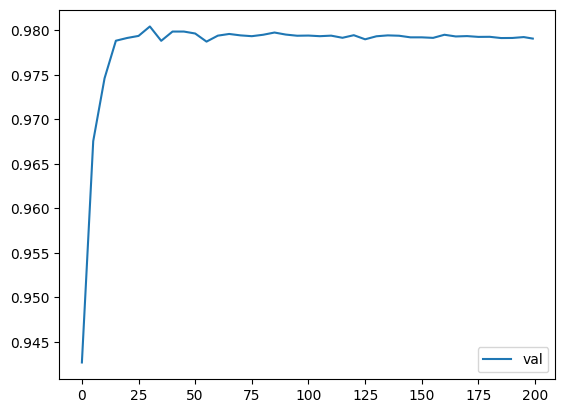

In [86]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

### XGBoost parameter tuning
**Tuning Eta**

Eta = 0.3

In [87]:
scores = {}

In [88]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [89]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [90]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,0.94753,0.94269
1,5,0.99085,0.96755
2,10,0.99787,0.97461
3,15,0.99888,0.97883
4,20,0.99948,0.97914
5,25,0.99968,0.97937
6,30,0.99988,0.98043
7,35,0.99996,0.97882
8,40,0.99999,0.97986
9,45,1.00000,0.97986


---
Eta = 1.0

In [91]:
%%capture output

xgb_params = {
    'eta': 1.0,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [92]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [93]:
scores['eta=1.0']

,num_iter,train_auc,val_auc
0,0,0.94753,0.94269
1,5,0.99873,0.97549
2,10,0.99992,0.97384
3,15,1.00000,0.97503
4,20,1.00000,0.97597
5,25,1.00000,0.97676
6,30,1.00000,0.97818
7,35,1.00000,0.97875
8,40,1.00000,0.97846
9,45,1.00000,0.97832


---
Eta = 0.1

In [94]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [95]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [96]:
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,0.94753,0.94269
1,5,0.97455,0.95386
2,10,0.98402,0.96119
3,15,0.99100,0.96488
4,20,0.99617,0.97362
5,25,0.99739,0.97435
6,30,0.99800,0.97644
7,35,0.99832,0.97613
8,40,0.99870,0.97836
9,45,0.99891,0.98050


---
Eta = 0.05

In [97]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [98]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.05'

In [99]:
scores['eta=0.05']

,num_iter,train_auc,val_auc
0,0,0.94753,0.94269
1,5,0.96415,0.95171
2,10,0.97443,0.95382
3,15,0.98354,0.96098
4,20,0.98391,0.96097
5,25,0.98495,0.96640
6,30,0.98807,0.96585
7,35,0.99263,0.96922
8,40,0.99390,0.97328
9,45,0.99655,0.97424


---
Eta = 0.01

In [100]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [101]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [102]:
scores['eta=0.01']

,num_iter,train_auc,val_auc
0,0,0.94753,0.94269
1,5,0.95710,0.94536
2,10,0.95768,0.94542
3,15,0.96387,0.95160
4,20,0.96403,0.95158
5,25,0.96414,0.95164
6,30,0.96730,0.95149
7,35,0.96737,0.95142
8,40,0.96837,0.95123
9,45,0.97442,0.95083


**Plotting Eta**

In [103]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

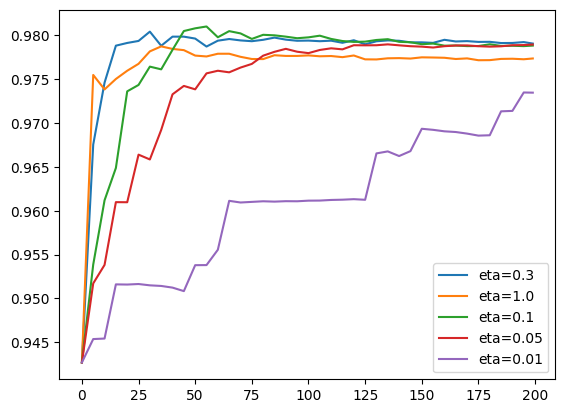

In [104]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

Look at extrem and middle curves :

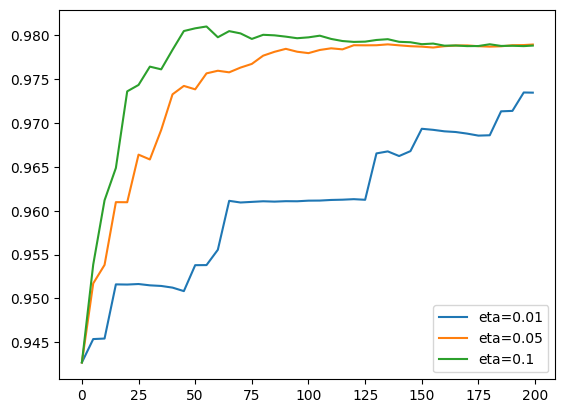

In [105]:
etas = ['eta=0.01', 'eta=0.05', 'eta=0.1']
for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

The '**eta=0.1**' model appears to be the best choice.

**Tuning max_depth**

max_depth=6

In [106]:
scores = {}

In [107]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [108]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=6'

---
max_depth=3

In [109]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [110]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

---
max_depth=4

In [111]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [112]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=4'

---
max_depth=5

In [113]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [114]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=5'

---
max_depth=10

In [115]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [116]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

**Plotting max_depth**

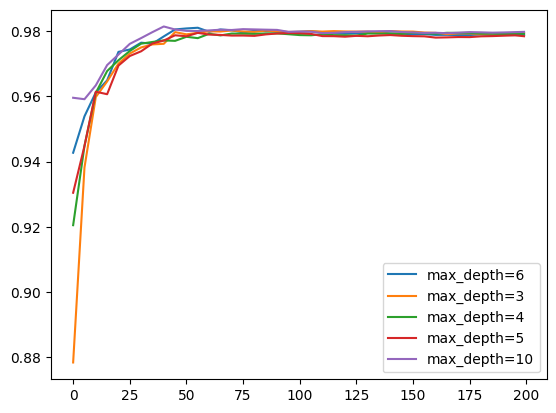

In [117]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

Let's have a focus :

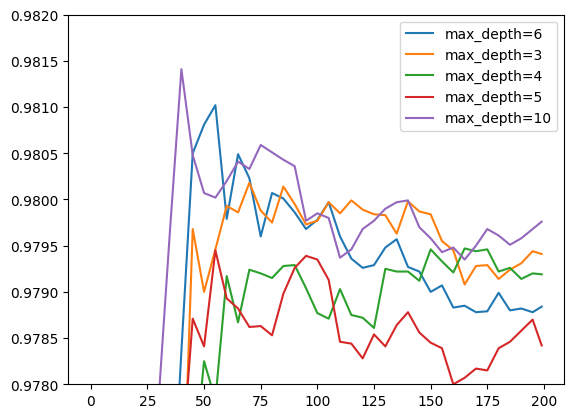

In [118]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.978, 0.982)
plt.legend()

'**max_depth=10**' is now fixed.

**Tuning min_child_weight**

min_child_weight=1

In [119]:
scores = {}

In [120]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [121]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

---
min_child_weight=10

In [122]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [123]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

---
min_child_weight=10

In [124]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [125]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

**Plotting min_child_weight**

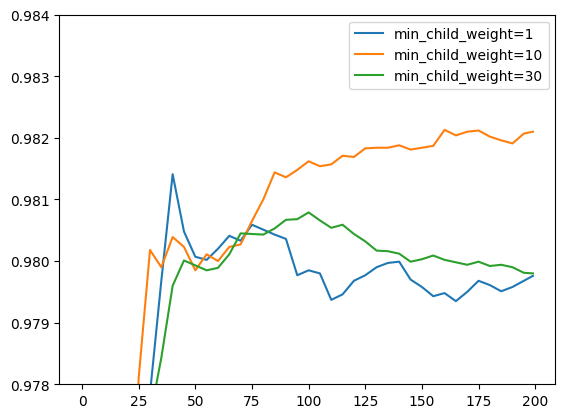

In [126]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.ylim(0.978, 0.984)
plt.legend()

'**min_child_weight=10**' is the best choice.

In [127]:
scores['min_child_weight=10']

,num_iter,train_auc,val_auc
0,0,0.97849,0.95835
1,5,0.98552,0.96063
2,10,0.98974,0.96674
3,15,0.99173,0.97309
4,20,0.99277,0.97382
5,25,0.99363,0.97810
6,30,0.99421,0.98018
7,35,0.99471,0.97990
8,40,0.99515,0.98039
9,45,0.99549,0.98023


Looking for optimum iterations number :

In [128]:
scores = {}

In [129]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=1,
                  evals=watchlist)

In [130]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=10'

In [131]:
scores['min_child_weight=10'].iloc[150: 170]

,num_iter,train_auc,val_auc
150,150,0.99780,0.98184
151,151,0.99781,0.98185
152,152,0.99782,0.98185
153,153,0.99782,0.98185
154,154,0.99783,0.98188
155,155,0.99784,0.98187
156,156,0.99785,0.98195
157,157,0.99786,0.98199
158,158,0.99787,0.98213
159,159,0.99787,0.98219


Model with best params :

In [132]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=159)

## Selecting the final model
### Choosing between XGBoost, random forest and decision tree
Retrain the best model of each type

In [133]:
dt = DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=39)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=100, random_state=39)

In [134]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.9666573165030388)

In [135]:
rf = RandomForestClassifier(n_estimators=190,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=39,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=190,
                       n_jobs=-1, random_state=39)

In [136]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.9768443197755959)

In [137]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=159)

In [138]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.9821318373071529)

**XGBoost** model has the best AUC score.

It'll be used to train the final model.
### Training the final model

In [139]:
df_full_train

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,64.739652,45.638355,1.954045,45.878434,turbine,san_francisco,0
1,75.062410,29.169678,1.642641,47.537256,turbine,new_york,0
2,77.556658,24.155665,2.706188,49.858019,compressor,san_francisco,0
3,67.057575,33.965620,2.489974,44.818347,pump,houston,0
4,77.910319,38.195755,1.591621,49.253946,compressor,san_francisco,0
...,...,...,...,...,...,...,...
6132,56.072645,34.278057,2.549625,49.022891,compressor,san_francisco,0
6133,78.743892,37.054266,1.544614,55.851687,turbine,chicago,0
6134,64.172413,31.871803,0.887800,69.478910,turbine,chicago,0
6135,73.819355,39.644541,1.124871,50.169142,pump,new_york,0


In [140]:
del df_full_train['faulty']
df_full_train.head(1)

,temperature,pressure,vibration,humidity,equipment,location
0,64.739652,45.638355,1.954045,45.878434,turbine,san_francisco


In [141]:
y_full_train

array([0, 0, 0, ..., 0, 0, 0], shape=(6137,))

In [142]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [143]:
feature_names = list(dv.get_feature_names_out())
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                         feature_names=feature_names)

dtest = xgb.DMatrix(X_test, feature_names=feature_names)

In [144]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'seed': 39,
    'verbosity': 1
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=159)

### Evaluate the final model

In [145]:
y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred)

np.float64(0.9721460435863684)

The model doesn't overfit.
## Deploying Machine Learning Models
### Saving the model to pickle

In [146]:
with open('model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)

### Loading the model with Pickle

In [147]:
with open('model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

dv, model

(DictVectorizer(sparse=False), <xgboost.core.Booster at 0x27dc1da1290>)

### Testing the model

In [148]:
equipment = df_test.iloc[-1].to_dict()
equipment

{'temperature': 69.94045290787271,
 'pressure': 26.18938696984232,
 'vibration': 0.6971832984686062,
 'humidity': 52.640224489963536,
 'equipment': 'turbine',
 'location': 'atlanta'}

In [149]:
X = dv.transform([equipment])
X

array([[ 0.        ,  0.        ,  1.        , 52.64022449,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        , 26.18938697,
        69.94045291,  0.6971833 ]])

In [150]:
feature_names = list(dv.get_feature_names_out())
dX = xgb.DMatrix(X, feature_names=feature_names)

In [151]:
model.predict(dX)[0]

np.float32(0.00028019093)

This machine is going to work fine !